# Extracting morally ambiguous stories from r/AmITheAsshole
Natalia Vélez, December 2022

In [1]:
%matplotlib inline

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from scipy.stats import beta

from convokit import Corpus
from convokit import download
from convokit.text_processing import TextProcessor, TextParser

sns.set_context('talk')
sns.set_style('white')

## Download corpus

In [2]:
corpus = Corpus('data/AmItheAsshole.corpus')
corpus.print_summary_stats()

Number of Speakers: 42202
Number of Utterances: 295027
Number of Conversations: 14371


How many comments did each conversation get?

min          2.0
max       2826.0
median      12.0
Name: num_comments, dtype: float64


[[<matplotlib.axis.XTick at 0x2b8e023c63a0>,
 [Text(0, 0, '1'), Text(1, 0, '10'), Text(2, 0, '100'), Text(3, 0, '1000')],
 Text(0.5, 15.439999999999998, '# Comments')]

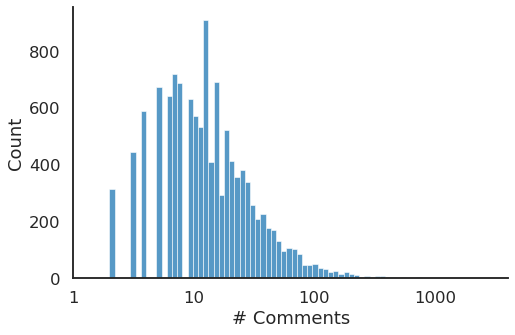

In [3]:
num_comments = (
    corpus.get_attribute_table('conversation',['num_comments'])
    .sort_values(by='num_comments', ascending=False)
)
num_comments = num_comments[num_comments > 1]
num_comments['log_comments'] = np.log10(num_comments.num_comments)

print(num_comments.num_comments.agg(['min', 'max', 'median']))
g = sns.displot(num_comments.log_comments,aspect=1.5)
g.axes[0,0].set(xticks = np.arange(4), xticklabels = [10**x for x in range(4)], 
                xlabel='# Comments')

Load conversations:

In [43]:
speaker_blacklist = ['[deleted]', 'DeltaBot','AutoModerator']
valid_judgments = 'YTA|NTA|ESH|NAH' 

def utterance_is_valid(utterance):
    is_comment = utterance.id != utterance.conversation_id
    valid_user = utterance.speaker.id not in speaker_blacklist
    return is_comment & valid_user

def extract_judgment(utterance):
    judgments = re.findall(valid_judgments, utterance)
    return np.unique(judgments).tolist()

convo_list = []
for convo_id, _ in num_comments.iterrows():
    convo_comments = [(u.text, u.meta['score']) for u in corpus.get_conversation(convo_id).iter_utterances()
                      if utterance_is_valid(u)]
    
    if len(convo_comments):
        convo_utterances, convo_upvotes = zip(*convo_comments)
        convo_judgments = [extract_judgment(u) for u in convo_utterances]
        convo_votes = [(u[0][0], u[1]) for u in zip(convo_judgments, convo_upvotes) if len(u[0]) == 1]

        convo_df = (
            pd.DataFrame(convo_votes, columns=['judgment', 'score'])
            .groupby('judgment')
            ['score'].agg('sum')
            .reset_index()
            .assign(conversation = convo_id)
        )

        convo_list.append(convo_df)

Assemble dataframe of votes:

In [47]:
aita_df = pd.concat(convo_list)
print(aita_df.shape)
print('Loaded %i conversations' % aita_df.conversation.nunique())
aita_df.head()

(4167, 3)
Loaded 3633 conversations


,judgment,score,conversation
0,NTA,-72.0,9srqsi
1,YTA,44118.0,9srqsi
0,YTA,12336.0,9t467y
0,NTA,2165.0,9mw228
1,YTA,-2.0,9mw228


Dominant judgments?

In [48]:
dominant_judgment = (
    aita_df.sort_values('score', ascending=False)
    .drop_duplicates(['conversation'])
)
dominant_judgment.groupby('judgment')['conversation'].agg('nunique')

judgment
ESH       1
NAH       1
NTA    3002
YTA     629
Name: conversation, dtype: int64

## Compute "moral entropy" score

As we found in the analyses above, ESH and NAH verdicts are much less common, so we'll just focus on NTA/YTA votes so that we can model judgments as a binary decision.

In order to convert votes into non-negative counts (both for plotting and for modeling), we'll count negative votes for one verdict into positive votes for the opposite verdict.

***New!*** In place of using the beta-binomial model, I instead operationalized "ambiguity" as the minimum of YTA and NTA votes. This measure prioritizes stories that have large numbers of votes for both verdicts.

In [92]:
aita_wide = (
    aita_df.pivot(index='conversation',columns='judgment',values='score')
    .fillna(0)
    .drop(columns=['ESH', 'NAH'])
)

# Convert negative votes into positive votes for the other verdict
# (There's probably a less redundant way of doing this)
aita_wide['NTA_nonneg'] = np.where(
    aita_wide['YTA'] < 0, 
    aita_wide['NTA']-aita_wide['YTA'], 
    aita_wide['NTA']
)

aita_wide['YTA_nonneg'] = np.where(
    aita_wide['NTA'] < 0, 
    aita_wide['YTA']-aita_wide['NTA'], 
    aita_wide['YTA']
)

# Log-transform non-negative votes
aita_wide[['NTA_nonneg', 'YTA_nonneg']] = np.where(
    aita_wide[['NTA_nonneg', 'YTA_nonneg']] < 0, 0, aita_wide[['NTA_nonneg', 'YTA_nonneg']])

aita_wide[['NTA_nonneg_log', 'YTA_nonneg_log']] = (
    np.log10(aita_wide[['NTA_nonneg', 'YTA_nonneg']]+1)
)

# Ambiguity of judgments
aita_wide['total_votes'] = aita_wide['NTA_nonneg']+aita_wide['YTA_nonneg']
aita_wide = aita_wide[aita_wide.total_votes > 0]
aita_wide['ambiguity'] = aita_wide[['NTA_nonneg', 'YTA_nonneg']].apply(min, axis=1)

aita_wide.head()

judgment,NTA,YTA,NTA_nonneg,YTA_nonneg,NTA_nonneg_log,YTA_nonneg_log,total_votes,ambiguity
conversation,,,,,,,,
2hyfpw,12.0,0.0,12.0,0.0,1.113943,0.000000,12.0,0.0
2muqyf,3.0,0.0,3.0,0.0,0.602060,0.000000,3.0,0.0
366fog,1.0,0.0,1.0,0.0,0.301030,0.000000,1.0,0.0
39eblq,-11.0,0.0,0.0,11.0,0.000000,1.079181,11.0,0.0
3hd7xv,0.0,18.0,0.0,18.0,0.000000,1.278754,18.0,0.0


## Most ambiguous dilemmas

Identify most ambiguous stories:

In [100]:
most_ambiguous = aita_wide.sort_values('ambiguity', ascending=False).head(25)
most_ambiguous

judgment,NTA,YTA,NTA_nonneg,YTA_nonneg,NTA_nonneg_log,YTA_nonneg_log,total_votes,ambiguity
conversation,,,,,,,,
9s2spi,895.0,1477.0,895.0,1477.0,2.952308,3.169674,2372.0,895.0
9qib9f,770.0,1978.0,770.0,1978.0,2.887054,3.296446,2748.0,770.0
9qz6lq,699.0,3529.0,699.0,3529.0,2.845098,3.547775,4228.0,699.0
9qf1n8,434.0,876.0,434.0,876.0,2.638489,2.943000,1310.0,434.0
9rmasr,190.0,297.0,190.0,297.0,2.281033,2.474216,487.0,190.0
9svj51,151.0,350.0,151.0,350.0,2.181844,2.545307,501.0,151.0
9sbypw,72.0,471.0,72.0,471.0,1.863323,2.673942,543.0,72.0
9qz5bh,969.0,70.0,969.0,70.0,2.986772,1.851258,1039.0,70.0
9lxopr,66.0,161.0,66.0,161.0,1.826075,2.209515,227.0,66.0


Plot NTA vs. YTA votes, highlighting most ambiguous stories:

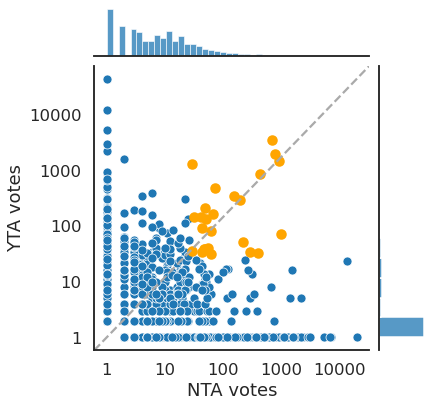

In [101]:
tick_range = np.arange(5)
g = sns.jointplot(data=aita_wide, x='NTA_nonneg_log', y='YTA_nonneg_log')
g.ax_joint.scatter(most_ambiguous.NTA_nonneg_log, most_ambiguous.YTA_nonneg_log, color='orange')

g.set_axis_labels(xlabel='NTA votes', ylabel='YTA votes')
g.ax_joint.set(xticks=tick_range, xticklabels=[10**x for x in tick_range],
               yticks=tick_range, yticklabels=[10**x for x in tick_range])
g.ax_joint.plot([0, 1], [0, 1], transform=g.ax_joint.transAxes, color='#aaa', linestyle='--')

In [102]:
for convo_id,row in most_ambiguous.iterrows():
    print(corpus.get_utterance(convo_id).text)
    print('======= %i YTA, %i NTA =======' % (row.YTA, row.NTA))
    print('=================================== \n')

This might be a bit long, so I'm sorry in advance. 


This whole episode went down about a year ago. Basically, I was doing an exchange program at a college in Japan. The classes were all co educational with Japanese and foreign students. My program only had about 35 or so people, so almost everyone was on a first name basis with each other and we were a fairly tight knit group. 


 Because of this, we often had class parties where everyone hung out and talked/drank/etc... At one of these parties, I noticed that one of my female Japanese friends was being cornered and forced to talk with another American exchange student, and was looking a little bit uncomfortable. I went over and asked her if she could go help me get more drinks from the supermarket, and she used the excuse to hurry out of there. 




From now on, I'm going to call this dickhead "D"




I was hoping this would be a one and done thing, but in the following days I noticed that my friend seemed a little on edge around D.